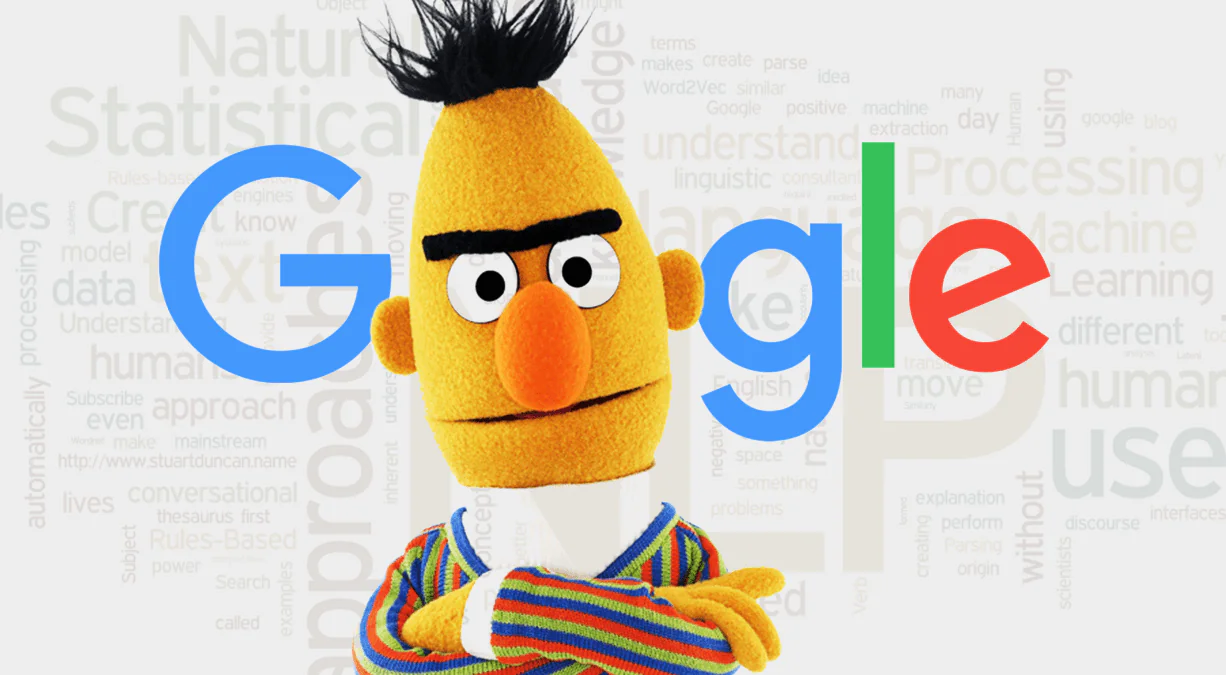

In [195]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Libraries**

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import math
import random

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import tqdm
from tqdm import tqdm

import sys

import sklearn
from sklearn.metrics import roc_auc_score

import transformers
from transformers import BertTokenizer, AdamW

import warnings
warnings.filterwarnings('ignore')

### **Data**

In [197]:
class SMSdataset(Dataset):
    def __init__(self, messages, label, tokenizer, max_len):
        self.messages = messages
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.messages)

    def __getitem__(self, idx):
        sms = str(self.messages[idx])
        label = self.label[idx]
        sms_len = min(50, len(sms.split()))

        encoding = self.tokenizer.encode_plus(
            sms,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'sms': sms,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten().type(torch.bool),
            'label': torch.tensor(label, dtype=torch.long),
            'sms_len': sms_len
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [198]:
df1 = pd.read_csv('https://raw.githubusercontent.com/animesharma3/SPAM-SMS-Detection/master/spam_sms_collection.csv')[['msg', 'spam']]
df1 = df1.rename(columns={'msg': 'text', 'spam': 'label'})

df2 = pd.read_csv('/content/train.csv').reset_index()
df2 = df2.drop(columns={'index', 'id'})

test_df = pd.read_csv('/content/test.csv').reset_index()
test_df = test_df.drop(columns={'index', 'id'})

df = pd.concat((df1, df2))
df = df.fillna(-1)
df = df.reset_index().drop(columns={'index'})

In [199]:
df.head()

,text,label
0,go jurong point crazy available bugis n great ...,0.0
1,ok lar joking wif u oni,0.0
2,free entry wkly comp win fa cup final tkts st ...,1.0
3,u dun say early hor u c already say,0.0
4,nah think go usf life around though,0.0


In [200]:
max_len = 50

train_data = SMSdataset(df['text'].values,
                  df['label'].values.astype(np.compat.long),
                  tokenizer,
                  max_len=max_len
                  )

test_data = SMSdataset(test_df['text'].values,
                  torch.zeros(len(test_df)),
                  tokenizer,
                  max_len=max_len
                  )

### **BERT configuration**

In [201]:
class Config():
    def __init__(self, tok_size=None, 
                 d_model=256,
                 n_layers=8,
                 n_heads=8,
                 n_segments=2,
                 p_drop_hidden=0.3,
                 p_drop_attn=0.3,
                 p_mask_token=0.15,
                 max_len=256,
                 device=None,
                 
                 batch_size=64,
                 max_epochs=1000,
                 learning_rate=1e-3
                 ):
        
        self.tok_size = tok_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_segments = n_segments
        self.p_drop_hidden = p_drop_hidden
        self.p_drop_attn = p_drop_attn
        self.p_mask_token = p_mask_token
        self.max_len = max_len
        self.device = device

        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
    
    def show_params(self):
        print('----------------------')
        print('token size (tok_size):', self.tok_size)
        print('hidden dimension (d_model):', self.d_model)
        print('number layers (n_layers):', self.n_layers)
        print('number heads (n_heads):', self.n_heads)
        print('number segments (n_segments):', self.n_segments)
        print('dropout prob hidden (p_drop_hidden):', self.p_drop_hidden)
        print('dropout prob attention (p_drop_attn):', self.p_drop_attn)
        print('prob of mask token (p_drop_attn):', self.p_mask_token)
        print('max lenght (max_len):', self.max_len)
        print('device (device):', self.device)
        
        print('batch size (batch_size):', self.batch_size)
        print('max epochs (max_epochs):', self.max_epochs)
        print('----------------------')

cfg = Config(tok_size=train_data.tokenizer.vocab_size, 
             d_model=512,
             n_layers=1,
             n_heads=4,
             n_segments=2,
             p_drop_hidden=0.1,
             p_drop_attn=0.1,
             p_mask_token=0.3,
             max_len=max_len,
             device=torch.device('cuda' if torch.cuda.is_available() 
                                                 else 'cpu'),
             batch_size=256,
             max_epochs=1,
             learning_rate=1e-4
             )

cfg.show_params()

----------------------
token size (tok_size): 28996
hidden dimension (d_model): 512
number layers (n_layers): 1
number heads (n_heads): 4
number segments (n_segments): 2
dropout prob hidden (p_drop_hidden): 0.1
dropout prob attention (p_drop_attn): 0.1
prob of mask token (p_drop_attn): 0.3
max lenght (max_len): 50
device (device): cuda
batch size (batch_size): 256
max epochs (max_epochs): 1
----------------------


In [202]:
train_data_loader = torch.utils.data.DataLoader(
                train_data, batch_size=cfg.batch_size,
                drop_last=True
)

test_data_loader = torch.utils.data.DataLoader(
                test_data, batch_size=1,
                drop_last=False
)

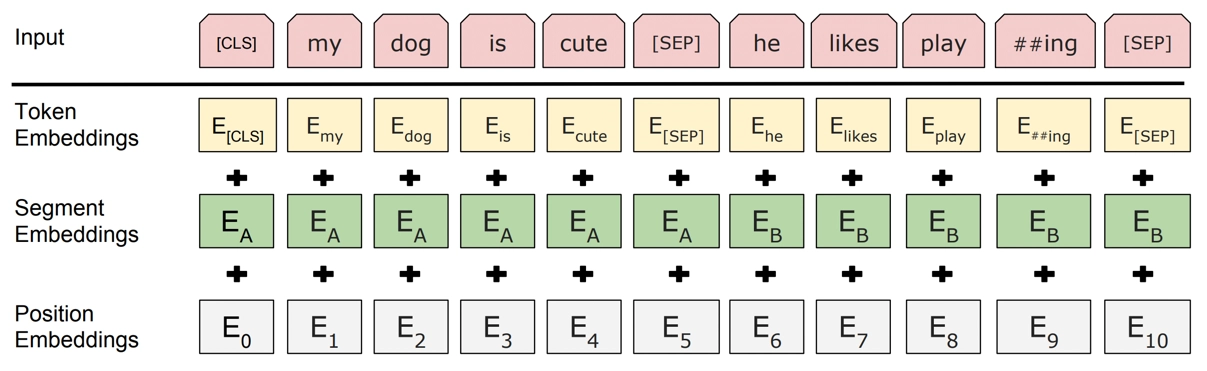

In [203]:
class Embedding(nn.Module):

    def __init__(self):
        super(Embedding, self).__init__()

        self.token_emb = nn.Embedding(cfg.tok_size, cfg.d_model)
        self.segment_emb = nn.Embedding(cfg.tok_size, cfg.d_model)

        self.norm = nn.LayerNorm(cfg.d_model)

    def forward(self, tokens: torch.Tensor):

        embedding = self.token_emb(tokens)

        return self.norm(embedding)

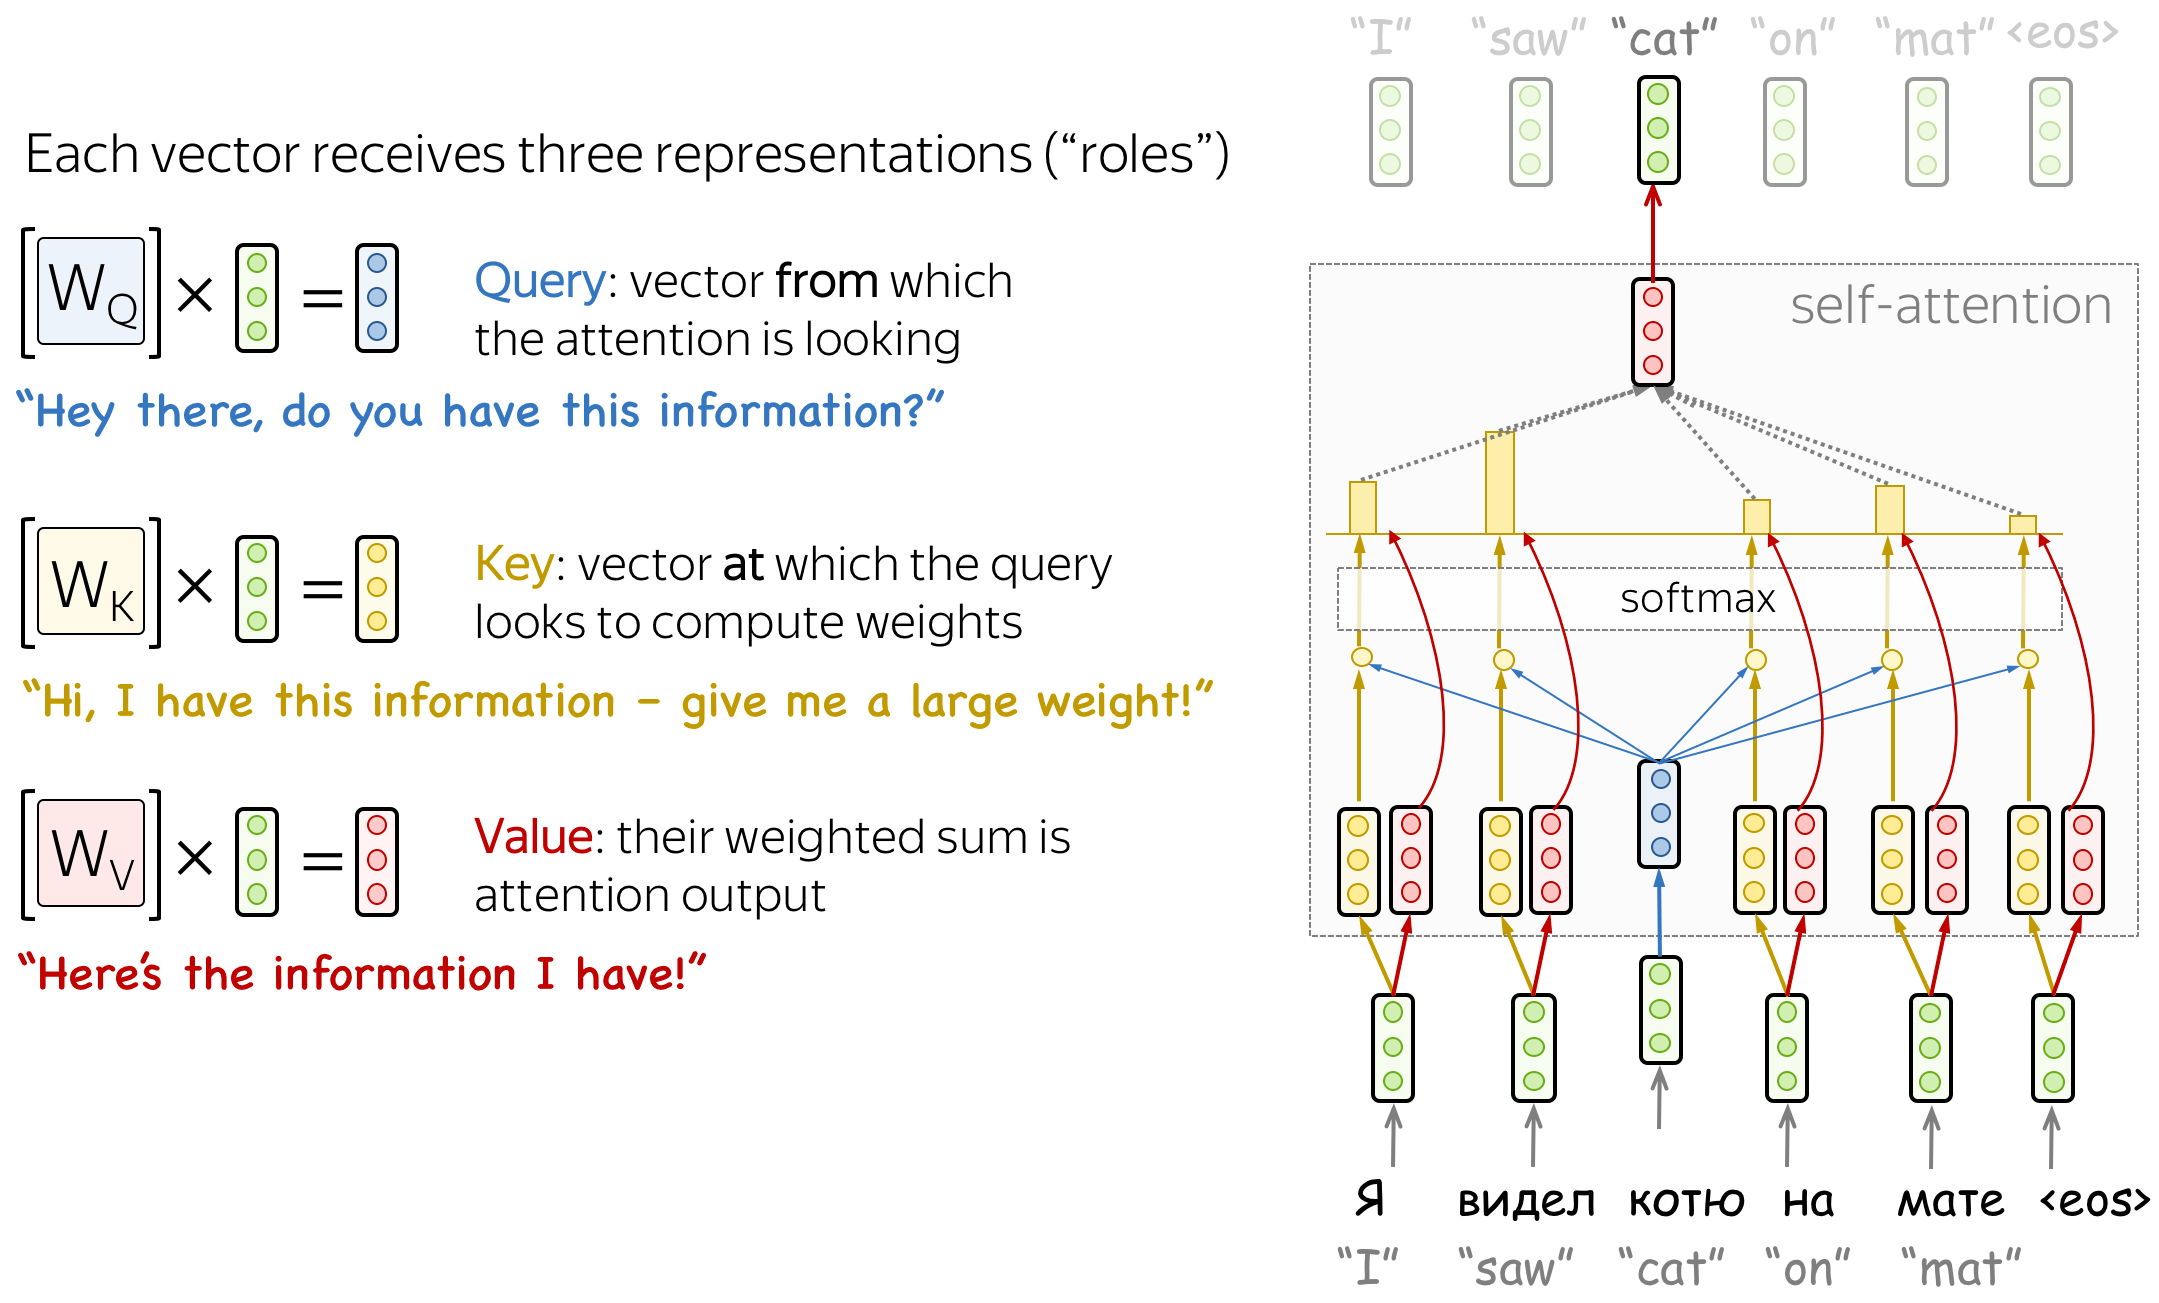

In [204]:
class AttentionHead(nn.Module):
    
    def __init__(self):
        super(AttentionHead, self).__init__()

        self.softmax = nn.Softmax(dim=1)

        self.query = nn.Linear(cfg.d_model, cfg.d_model)
        self.key = nn.Linear(cfg.d_model, cfg.d_model)
        self.value = nn.Linear(cfg.d_model, cfg.d_model)

    def forward(self, tokens_emb: torch.Tensor, attn_mask: torch.Tensor):

        q = self.query(tokens_emb)
        k = self.key(tokens_emb)
        v = self.value(tokens_emb)

        d_k = q.size()[-1]

        attn_weights = torch.bmm(q, k.transpose(-1, -2)) / np.sqrt(d_k)

        if attn_mask is not None:
            attn_weights = attn_weights.masked_fill(attn_mask==False, -1e19)

        attn_weights = self.softmax(attn_weights)
        context = torch.bmm(attn_weights, v)

        return context

In [205]:
class MultiHeadAttention(nn.Module):
  
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        
        self.heads = nn.ModuleList([
            AttentionHead() for _ in range(cfg.n_heads)])
        
        self.linear = nn.Linear(cfg.d_model * cfg.n_heads,
                                cfg.d_model)
        self.norm = nn.LayerNorm(cfg.d_model)

    def forward(self, embedding: torch.Tensor, attn_mask: torch.Tensor):

        attn_heads_outp = [head(embedding, attn_mask) for head in self.heads]

        context = torch.cat(attn_heads_outp, dim=-1)
        context = self.linear(context)

        return self.norm(context)

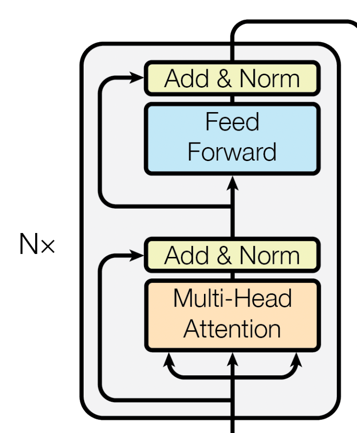

In [206]:
class Encoder(nn.Module):  
  
    def __init__(self):  
        super(Encoder, self).__init__()  
  
        self.attention = MultiHeadAttention() 
        self.feed_forward = nn.Sequential(  
            nn.Linear(cfg.d_model, cfg.d_model),  
            nn.Dropout(cfg.p_drop_hidden),  
            nn.ReLU(),  
            nn.Linear(cfg.d_model, cfg.d_model),  
            nn.Dropout(cfg.p_drop_hidden)  
        )
        self.norm = nn.LayerNorm(cfg.d_model)  
  
    def forward(self, tokens_emb, attention_mask):  

        context = self.attention(tokens_emb, attention_mask)  
        output = self.feed_forward(context)
        
        return self.norm(output)

In [207]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()

        self.layers = nn.ModuleList([Encoder() for _ in range(cfg.n_layers)])
        self.embedding = Embedding()

        self.gelu = nn.GELU()
        self.softmax = nn.LogSoftmax(dim=1)

        self.linear = nn.Linear(cfg.d_model, cfg.d_model)
        self.norm = nn.LayerNorm(cfg.d_model)

        self.clf_layer = nn.Linear(cfg.d_model, 2)
        self.decoder = nn.Linear(cfg.d_model, cfg.tok_size)

    def forward(self, tokens: torch.Tensor, attn_mask: torch.Tensor):
        output = self.embedding(tokens) 

        for layer in self.layers:
            output = layer.forward(output, attn_mask)

        lm_output = self.norm(self.gelu(self.linear(output)))
        lm_output = self.decoder(lm_output)

        clf_token = output[:, 0, :]
        clf_output = self.clf_layer(clf_token)

        return lm_output, clf_output


model = BERT().to(cfg.device)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

lm_criterion = nn.CrossEntropyLoss(ignore_index=0)
clf_criterion = nn.CrossEntropyLoss()

checkpoint = torch.load('/content/MODEL.pth')
model.load_state_dict(checkpoint)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 49,560,902 trainable parameters


In [208]:
def make_mask(tokens, attn_mask, sms_len):
    num_batches = tokens.shape[0]
    masked_tokens = torch.zeros_like(tokens)
    num_mask_tokens = [0.15 * sms_len for sms_len in sms_lens]

    pos_tokens = []
    for i, sms_len in enumerate(sms_lens):
        if sms_len >= 4:
            pos_tokens.append(random.sample(range(1, sms_len), math.ceil(num_mask_tokens[i])))
        else:
            pos_tokens.append([])

    for batch in range(num_batches):
        for pos in pos_tokens[batch]:
            if random.random() < 0.8:
                masked_tokens[batch][pos] = tokens[batch][pos]
                tokens[batch][pos] = train_data.tokenizer.vocab['[MASK]']

    return tokens, torch.tensor(masked_tokens, dtype=torch.long), attn_mask.type(torch.bool)

In [209]:
for epoch in range(cfg.max_epochs):
    epoch_lm_loss = 0
    epoch_clf_loss = 0

    for step, batch in enumerate(tqdm(train_data_loader, file=sys.stdout)):
        optimizer.zero_grad()

        tokens = batch['input_ids'].to(cfg.device)
        targets = batch['label'].to(cfg.device)
        attn_masks= batch['attention_mask'].to(cfg.device).view(cfg.batch_size, 1, 50)
        sms_lens = batch['sms_len']

        tokens, masked_tokens, attn_mask = make_mask(tokens.clone(), attn_masks.clone(), sms_lens)

        lm_output, clf_output = model.forward(tokens.clone(), attn_masks)

        lm_loss = lm_criterion(lm_output.transpose(1, 2), masked_tokens)
        clf_loss = clf_criterion(clf_output, targets)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        epoch_lm_loss += lm_loss.item()
        epoch_clf_loss += clf_loss.item()

        loss = lm_loss + clf_loss
        loss.backward()
        optimizer.step()

    print('language modeling loss:', epoch_lm_loss / len(train_data_loader))
    print('classification loss:', epoch_clf_loss / len(train_data_loader))

100%|██████████| 38/38 [00:25<00:00,  1.50it/s]
language modeling loss: 1.541835700210772
classification loss: 9.688553632558021e-05


### **Classification prediction**

In [210]:
y_test = pd.read_csv('/content/preds_with_sklearn.csv')
predictions = []

model.eval()

for step, batch in enumerate(tqdm(test_data_loader, file=sys.stdout)):
    tokens = batch['input_ids'].to(cfg.device).view(1, cfg.max_len)
    mask = batch['attention_mask'].to(cfg.device)

    with torch.no_grad():
        lm_output, clf_output = model.forward(tokens, mask)
    prediction = clf_output.argmax()

    predictions.append(prediction.item())

print('classification modeling loss:', roc_auc_score(y_test['Predicted'].values, predictions))

ans = pd.DataFrame({'Id': y_test['Id'].values, 'Predicted': predictions})

ans.to_csv('ans.csv', index = False)

100%|██████████| 1394/1394 [00:07<00:00, 197.75it/s]
classification modeling loss: 0.967056743742137


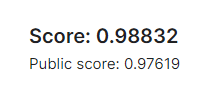

### **Language Modeling score prediction**

In [211]:
epoch_lm_loss = 0

for step, batch in enumerate(tqdm(test_data_loader, file=sys.stdout)):
    optimizer.zero_grad()
    
    tokens = batch['input_ids'].to(cfg.device)
    target = batch['label'].to(cfg.device)
    attn_mask = batch['attention_mask'].to(cfg.device)
    sms_lens = batch['sms_len']

    tokens, masked_tokens, attn_mask = make_mask(tokens.clone(), attn_mask.clone(), sms_lens)

    lm_output, clf_output = model.forward(tokens.clone(), attn_mask)

    lm_loss = lm_criterion(lm_output.transpose(1, 2), masked_tokens)

    epoch_lm_loss += float(str(lm_loss.item()).replace('nan', '0')) 

print('language modeling loss:', epoch_lm_loss / len(test_data_loader))

100%|██████████| 1394/1394 [00:10<00:00, 133.60it/s]
language modeling loss: 5.936730426521259
